In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def  forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op
        

In [10]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y)
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format
                (
                    epoch, b_i * len(X), len(train_dataloader.dataset),
                    100. * b_i / len(train_dataloader), loss.item()
                )
            )

In [11]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)

            # 배치별 손실 합
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()
            # 가장 가능성이 높은 예측을 얻기 위해 argmax를 사용
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()
    loss /= len(test_dataloader.dataset)
    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), 100. * success / len(test_dataloader.dataset)
    ))

In [6]:
!ls

drive  sample_data


In [12]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./sample_data', train=True, download=True,
                   transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302), (0.3069))
                    ])),
    batch_size = 32, shuffle = True
)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./sample_data', train = False, download = True,
                   transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1302), (0.3069))
                   ])),
    batch_size = 500, shuffle = False
)

In [13]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr = 0.5) # 데이터가 희소성이 있는 경우에 Adadelta가 효과적
# 다른 optim을 써보고 영향을 알아보는 것도 좋음

In [14]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924132
epoch: 1 [640/60000 (1%)]	 training loss: 1.313337
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678458
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477065
epoch: 1 [2240/60000 (4%)]	 training loss: 0.527093
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469393
epoch: 1 [2880/60000 (5%)]	 training loss: 0.239181
epoch: 1 [3200/60000 (5%)]	 training loss: 0.523922
epoch: 1 [3520/60000 (6%)]	 training loss: 0.269557
epoch: 1 [3840/60000 (6%)]	 training loss: 0.465786
epoch: 1 [4160/60000 (7%)]	 training loss: 0.414428
epoch: 1 [4480/60000 (7%)]	 training loss: 0.329391
epoch: 1 [4800/60000 (8%)]	 training loss: 0.491097
epoch: 1 [5120/60000 (9%)]	 training loss: 0.153555
epoch: 1 [5440/60000 (9%)]	 training loss: 0.369510
epoch: 1 [5760/60000 (10%)]	 training loss: 0.093413
epoch: 1 [6080/60

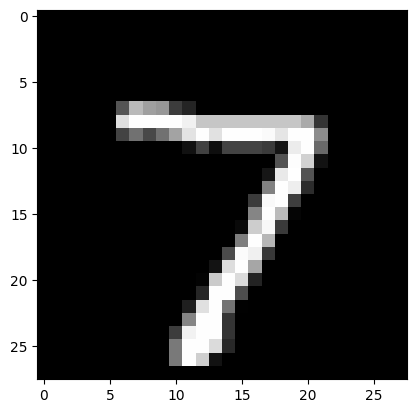

In [15]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation = 'none')
plt.show()

In [16]:
print(model(sample_data).data.max(1)[1][0])
print(sample_targets[0])

tensor(7)
tensor(7)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
